In [1]:
%%time
import os
import traceback
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import sqlalchemy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.utils import resample
import xgboost as xgb
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler




user='hifld_summer'
pw='hifld_summer'
name='hifld_summer'
host='moria'
port=2023
engine = sqlalchemy.create_engine(
    f'postgresql://{user}:{pw}@{host}:{port}/{name}'
    )

CPU times: total: 3.28 s
Wall time: 3.22 s


In [2]:
%%time
"MODEL SET-UP"
"Loading in the data from the database"

sql ="""
select * from results.all_features_w_class
"""
df = pd.read_sql_query(sql, con=engine)

CPU times: total: 53.9 s
Wall time: 1min 4s


In [3]:
df.columns

Index(['uuid', 'parcel_lid', 'use_code_std_lps', 'use_code_std_desc_lps',
       'geom', 'build_id', 'prim_occ', 'new_sqmeters', 'perimeter',
       'vertex_count', 'length', 'width', 'long_side', 'short_side',
       'ls_ratio', 'pp_compactness', 'min_bounding_circle_area',
       'reock_compactness', 'sch_compactness', 'lon', 'lat',
       'points_in_polygon_buffers', 'ls_ratios_mean', 'ls_ratios_std',
       'ls_ratios_min', 'ls_ratios_max', 'area_mean', 'area_std', 'area_min',
       'area_max', 'mh_flag'],
      dtype='object')

In [4]:
%%time
"Dropping unnecessary columns (leaving only features and label) and setting index"

df = df.drop(columns=['geom', 'use_code_std_lps', 'use_code_std_desc_lps', 'parcel_lid', 'build_id', 'prim_occ'])

df.set_index('uuid', inplace=True)

CPU times: total: 609 ms
Wall time: 609 ms


In [5]:
df.head(2)

,new_sqmeters,perimeter,vertex_count,length,width,long_side,short_side,ls_ratio,pp_compactness,min_bounding_circle_area,...,points_in_polygon_buffers,ls_ratios_mean,ls_ratios_std,ls_ratios_min,ls_ratios_max,area_mean,area_std,area_min,area_max,mh_flag
uuid,,,,,,,,,,,,,,,,,,,,,
{0cfa8287-702c-4398-9a13-dbc65516edcd},196.136943,59.511465,4,22.218432,16.746386,22.218432,16.746386,1.326760,0.695934,386.746271,...,17,1.560777,0.427064,1.102499,2.576856,124.478508,57.138154,49.033865,245.171992,0
{0cfa8681-5a11-405f-b741-76347be40cf1},153.248578,49.518624,4,13.327807,13.178267,13.327807,13.178267,1.011347,0.785361,239.347260,...,190,1.486693,0.366481,1.011137,2.965722,194.148351,172.201611,36.778514,1777.669633,0


In [6]:
%%time
"Seperating dataframe into x (features) and y (label)"

X = df.drop(columns=['mh_flag'], axis=1)
y = df['mh_flag']

CPU times: total: 172 ms
Wall time: 172 ms


In [8]:
%%time
"Splitting into training and testing datasets"

X_train_v1, X_test, y_train_v1, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

CPU times: total: 3.42 s
Wall time: 3.42 s


In [9]:
%%time
rus = RandomUnderSampler(random_state=0)
X_train, y_train = rus.fit_resample(X_train_v1, y_train_v1)

CPU times: total: 1.39 s
Wall time: 1.42 s


In [10]:
%%time
"Checking for class imbalance"

# df.mh_flag.value_counts(normalize=True)
print(y_train_v1.value_counts())
print(y_train.value_counts())

mh_flag
0    1551551
1     112753
Name: count, dtype: int64
mh_flag
0    112753
1    112753
Name: count, dtype: int64
CPU times: total: 31.2 ms
Wall time: 45.1 ms


In [11]:
%%time
"Standardizing training set and applying the standardization to the training set"

sc = StandardScaler()
sc.fit(X_train)

X_train_scaled = sc.transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

CPU times: total: 125 ms
Wall time: 136 ms


In [12]:
%%time
"Saving the standard scaler"

dump(sc, 'my_standard_scaler.pkl')

CPU times: total: 15.6 ms
Wall time: 7.99 ms


['my_standard_scaler.pkl']

In [13]:
%%time
"Loading the standard scaler back"

same_scaler = load('my_standard_scaler.pkl')

CPU times: total: 0 ns
Wall time: 1 ms


In [14]:
%%time
"Applying the standardization to the testing set"


X_test_scaled = same_scaler.transform(X_test)

X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

CPU times: total: 203 ms
Wall time: 200 ms


In [15]:
"-----CLASSIFICATION MODELS---------------------------------------------------------------------------------------------------------------------------"

'-----CLASSIFICATION MODELS---------------------------------------------------------------------------------------------------------------------------'

In [18]:
%%time
"LINEAR CLASSIFER (BASELINE MODEL)"

base_lr = LogisticRegression(random_state = 42, max_iter=1000)

CPU times: total: 0 ns
Wall time: 0 ns


In [19]:
%%time
"Fitting linear classifier"

base_lr.fit(X_train, y_train)

CPU times: total: 7.44 s
Wall time: 1.93 s


LogisticRegression(max_iter=1000, random_state=42)

In [20]:
%%time
"Using the trained linear classifier to predict on the testing set"

base_lr_predict = base_lr.predict(X_test)

CPU times: total: 266 ms
Wall time: 119 ms


In [21]:
%%time
"Checking validity of the linear classifier's output"

base_lr_predict

CPU times: total: 0 ns
Wall time: 0 ns


array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

In [22]:
%%time
"Creating a confusion matrix for the linear classifier"

lr_cmatrix = confusion_matrix(y_test, base_lr_predict)
print(lr_cmatrix)

[[502100 262311]
 [ 10556  44765]]
CPU times: total: 438 ms
Wall time: 451 ms


In [23]:
%%time
"Creating a classification report for the linear classifier"

print(classification_report(y_test, base_lr_predict))

              precision    recall  f1-score   support

           0       0.98      0.66      0.79    764411
           1       0.15      0.81      0.25     55321

    accuracy                           0.67    819732
   macro avg       0.56      0.73      0.52    819732
weighted avg       0.92      0.67      0.75    819732

CPU times: total: 1.58 s
Wall time: 1.59 s


CPU times: total: 141 ms
Wall time: 126 ms


<Axes: >

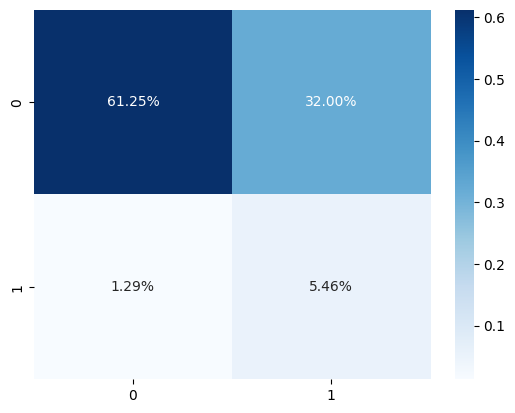

In [24]:
%%time
"Creating a heatmap for the linear classifier's confusion matrix"

sns.heatmap(lr_cmatrix/np.sum(lr_cmatrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [25]:
%%time
"DECISION TREE CLASSIFIER"

base_dt = DecisionTreeClassifier(random_state = 42)

CPU times: total: 0 ns
Wall time: 0 ns


In [26]:
%%time
"Fitting decision tree"

base_dt.fit(X_train, y_train)

CPU times: total: 11.1 s
Wall time: 11.1 s


DecisionTreeClassifier(random_state=42)

In [27]:
%%time
"Using the trained decision tree to predict on the testing set"

base_dt_predict = base_dt.predict(X_test)

CPU times: total: 500 ms
Wall time: 485 ms


In [28]:
%%time
"Checking validity of the decision tree's output"

base_dt_predict

CPU times: total: 0 ns
Wall time: 1 ms


array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

In [29]:
%%time
"Creating a confusion matrix for the decision tree"

dt_cmatrix = confusion_matrix(y_test, base_dt_predict)
print(dt_cmatrix)

[[540342 224069]
 [ 16459  38862]]
CPU times: total: 172 ms
Wall time: 183 ms


In [30]:
%%time
"Creating a classification report for the decision tree"

print(classification_report(y_test, base_dt_predict))

              precision    recall  f1-score   support

           0       0.97      0.71      0.82    764411
           1       0.15      0.70      0.24     55321

    accuracy                           0.71    819732
   macro avg       0.56      0.70      0.53    819732
weighted avg       0.91      0.71      0.78    819732

CPU times: total: 1.61 s
Wall time: 1.61 s


CPU times: total: 125 ms
Wall time: 103 ms


<Axes: >

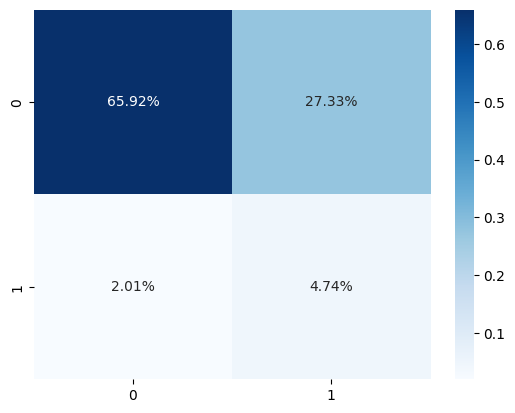

In [31]:
%%time
"Creating a heatmap for the decision tree's confusion matrix"

sns.heatmap(dt_cmatrix/np.sum(dt_cmatrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [32]:
%%time
"RANDOM FOREST CLASSIFIER"

base_rf = RandomForestClassifier(max_depth = 2, random_state = 42)

CPU times: total: 0 ns
Wall time: 0 ns


In [33]:
%%time
"Fitting random forest"

base_rf.fit(X_train, y_train)

CPU times: total: 23.2 s
Wall time: 23.2 s


RandomForestClassifier(max_depth=2, random_state=42)

In [34]:
%%time
"Using the trained random forest to predict on the testing set"

base_rf_predict = base_rf.predict(X_test)

CPU times: total: 4.8 s
Wall time: 4.8 s


In [35]:
%%time
"Checking validity of the random forest's output"

base_rf_predict

CPU times: total: 0 ns
Wall time: 0 ns


array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

In [36]:
%%time
"Creating a confusion matrix for the random forest"

rf_cmatrix = confusion_matrix(y_test, base_rf_predict)
print(rf_cmatrix)

[[532422 231989]
 [ 12048  43273]]
CPU times: total: 203 ms
Wall time: 214 ms


In [37]:
%%time
"Creating a classification report for the random forest"

print(classification_report(y_test, base_rf_predict))

              precision    recall  f1-score   support

           0       0.98      0.70      0.81    764411
           1       0.16      0.78      0.26     55321

    accuracy                           0.70    819732
   macro avg       0.57      0.74      0.54    819732
weighted avg       0.92      0.70      0.78    819732

CPU times: total: 1.8 s
Wall time: 1.81 s


CPU times: total: 93.8 ms
Wall time: 87.9 ms


<Axes: >

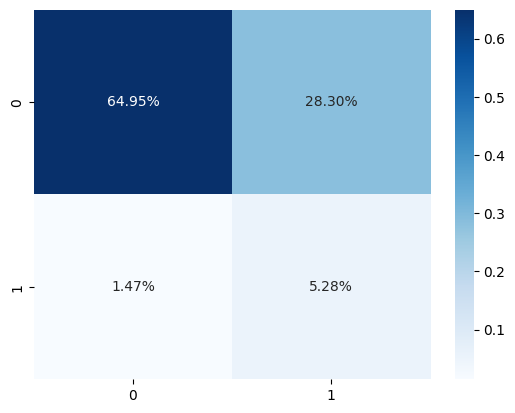

In [38]:
%%time
"Creating a heatmap for the random forest's confusion matrix"

sns.heatmap(rf_cmatrix/np.sum(rf_cmatrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [39]:
%%time
"XGBOOST CLASSIFIER"

base_xg = xgb.XGBClassifier(max_depth=2)

CPU times: total: 0 ns
Wall time: 0 ns


In [40]:
%%time
"Fitting random forest"

base_xg.fit(X_train, y_train)

CPU times: total: 6.36 s
Wall time: 934 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [41]:
%%time
"Using the trained random forest to predict on the testing set"

base_xg_predict = base_xg.predict(X_test)

CPU times: total: 1.5 s
Wall time: 208 ms


In [42]:
%%time
"Checking validity of the random forest's output"

base_xg_predict

CPU times: total: 0 ns
Wall time: 0 ns


array([0, 0, 1, ..., 0, 0, 1])

In [43]:
%%time
"Creating a confusion matrix for the random forest"

xg_cmatrix = confusion_matrix(y_test, base_xg_predict)
print(xg_cmatrix)

[[542975 221436]
 [  9362  45959]]
CPU times: total: 156 ms
Wall time: 160 ms


In [44]:
%%time
"Creating a classification report for the random forest"

print(classification_report(y_test, base_xg_predict))

              precision    recall  f1-score   support

           0       0.98      0.71      0.82    764411
           1       0.17      0.83      0.28     55321

    accuracy                           0.72    819732
   macro avg       0.58      0.77      0.55    819732
weighted avg       0.93      0.72      0.79    819732

CPU times: total: 1.59 s
Wall time: 1.6 s


CPU times: total: 78.1 ms
Wall time: 83.3 ms


<Axes: >

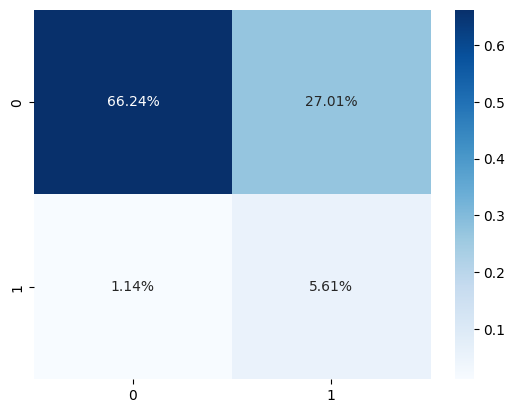

In [45]:
%%time
"Creating a heatmap for the random forest's confusion matrix"

sns.heatmap(xg_cmatrix/np.sum(xg_cmatrix), annot=True, 
            fmt='.2%', cmap='Blues')